import all required libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

Reading NC file

In [2]:
temp = xr.open_dataset('merged_temperature.nc')
temp 

<xarray.Dataset>
Dimensions:    (time: 15706, latitude: 33, longitude: 21)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 2022-12-31T12:00:00
  * latitude   (latitude) float32 19.0 18.75 18.5 18.25 ... 11.5 11.25 11.0
  * longitude  (longitude) float32 74.0 74.25 74.5 74.75 ... 78.5 78.75 79.0
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-22 07:41:44 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Selecting Temperature@2metres variable.

In [3]:
temperature = temp.variables['t2m']

In [4]:
temperature = np.array(temperature)
temperature

array([[[298.3776 , 298.9481 , 300.3774 , ..., 298.7858 , 298.38104,
         297.57272],
        [299.35785, 299.97113, 300.82303, ..., 298.41614, 298.64087,
         298.6586 ],
        [299.00012, 300.91052, 301.50455, ..., 299.0514 , 299.50626,
         300.33463],
        ...,
        [300.13687, 300.1315 , 300.2132 , ..., 298.96542, 298.45737,
         299.524  ],
        [300.12146, 300.12338, 300.1608 , ..., 300.38705, 299.61765,
         299.9106 ],
        [300.10565, 300.15115, 300.1704 , ..., 301.70923, 300.63336,
         300.27567]],

       [[297.23813, 297.94507, 298.7615 , ..., 299.5309 , 299.54056,
         299.16162],
        [298.11893, 298.84903, 299.46463, ..., 299.93915, 300.60138,
         300.48804],
        [297.8063 , 299.57794, 300.24173, ..., 299.32584, 301.32568,
         301.4548 ],
        ...,
        [299.89056, 299.94916, 300.01547, ..., 298.80045, 298.5703 ,
         299.70285],
        [299.88055, 299.98038, 300.05438, ..., 300.15768, 299.7599 ,
   

In [5]:
time = temp['time']
time

<xarray.DataArray 'time' (time: 15706)>
array(['1980-01-01T12:00:00.000000000', '1980-01-02T12:00:00.000000000',
       '1980-01-03T12:00:00.000000000', ..., '2022-12-29T12:00:00.000000000',
       '2022-12-30T12:00:00.000000000', '2022-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2022-12-31T12:00:00
Attributes:
    long_name:  time

In [6]:
lat = temp['latitude']
lat = np.array(lat)

In [7]:
max_lat = np.max(lat)
min_lat = np.min(lat)

In [8]:
lon = temp['longitude']
lon = np.array(lon)

In [9]:
max_lon = np.max(lon)
min_lon = np.min(lon)

In [10]:
temperature = temperature -273

In [11]:
np.nanmax(temperature)

43.151367

In [12]:
np.nanmin(temperature)

17.890137

In [13]:
temperature_rs = temperature.reshape(15706,33*21)

In [14]:
imputer = SimpleImputer(strategy='mean')
temperature_rs = imputer.fit_transform(temperature_rs)

In [15]:
temperature_rs.shape

(15706, 693)

In [16]:
temperature_rs[1,:]

array([24.238129, 24.945068, 25.761505, 26.447266, 25.80429 , 26.09726 ,
       26.995789, 27.585968, 27.753632, 27.865051, 28.03659 , 27.943298,
       27.87082 , 27.910156, 27.538544, 26.980377, 26.35321 , 25.706787,
       26.530914, 26.540558, 26.161621, 25.118927, 25.84903 , 26.46463 ,
       27.470306, 27.22052 , 26.123077, 25.84903 , 25.476257, 26.126556,
       27.222473, 27.114899, 27.21051 , 26.374817, 26.849335, 27.181213,
       26.749878, 26.46463 , 26.54248 , 26.939148, 27.60138 , 27.488037,
       24.806305, 26.577942, 27.24173 , 28.222748, 28.353424, 27.558197,
       26.316223, 25.718353, 26.26532 , 27.097565, 27.56012 , 27.121094,
       26.611084, 27.099487, 27.493835, 27.103333, 26.712463, 26.802307,
       26.325836, 28.325684, 28.454803, 24.570007, 27.040527, 27.866974,
       28.831818, 28.427826, 28.366943, 27.148071, 27.187378, 27.48227 ,
       27.00351 , 27.763275, 27.71048 , 27.62259 , 27.910156, 27.331543,
       26.935272, 26.240265, 25.941132, 26.191315, 

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_temp = scaler.fit_transform(temperature_rs)

In [18]:
scaled_temp[1,:]

array([0.24748099, 0.28708726, 0.29688233, 0.34350652, 0.29956943,
       0.3269559 , 0.34359008, 0.38315922, 0.389382  , 0.39499998,
       0.40153623, 0.39805776, 0.39522266, 0.3967207 , 0.38198948,
       0.35986376, 0.33489555, 0.3096264 , 0.34181488, 0.3420908 ,
       0.32730848, 0.29499078, 0.31640732, 0.32356375, 0.3693124 ,
       0.36881614, 0.32787883, 0.2705654 , 0.28805345, 0.2980833 ,
       0.35611218, 0.36393332, 0.36773264, 0.33601117, 0.35457915,
       0.36776215, 0.34911495, 0.33599597, 0.34165096, 0.35614568,
       0.38450038, 0.37974358, 0.2581119 , 0.31098175, 0.34041113,
       0.4121905 , 0.414598  , 0.38212138, 0.3350678 , 0.31081676,
       0.32224506, 0.36268413, 0.3867991 , 0.3547088 , 0.34164768,
       0.36477816, 0.37931347, 0.3642807 , 0.34934908, 0.35668254,
       0.3312307 , 0.41361833, 0.41728956, 0.28779787, 0.3329333 ,
       0.39405143, 0.4334694 , 0.41713125, 0.41463667, 0.36614788,
       0.36866432, 0.37575316, 0.36803734, 0.37962705, 0.38254

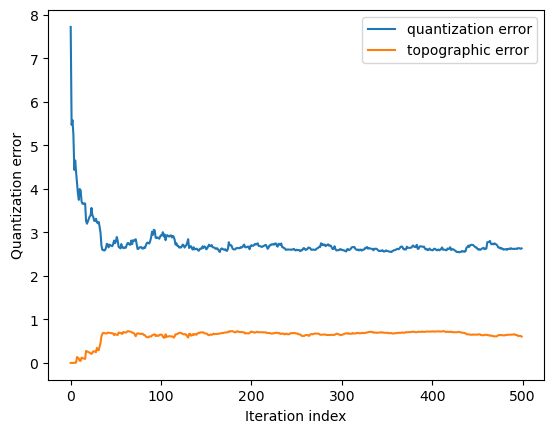

In [19]:
# Define the shape of the SOM grid (1 row, 3 columns)
# - Rows: som_shape[0]
# - Columns: som_shape[1]
# - Input features: data.shape[1]
# - Sigma (spread of the neighborhood function): 0.5 #neighborhood radius
#(It influences the size of the region around the winning node that gets updated during training.)
# - Learning rate: 0.5(The learning rate controls the step size in weight updates during training.)
# - Neighborhood function: Gaussian
#(The Gaussian neighborhood function is commonly used because it smoothly decreases with distance from the BMU. 
#It is defined by a Gaussian distribution and provides a gradual decrease in influence as nodes move away from the BMU
#This ensures a more continuous and natural adaptation of weights across the SOM grid.)
# - Random seed: 10

som_shape = (1, 3)


som = MiniSom(som_shape[0], som_shape[1], scaled_temp.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 500
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(scaled_temp))
    som.update(scaled_temp[rand_i], som.winner(scaled_temp[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(scaled_temp))
    t_error.append(som.topographic_error(scaled_temp))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('Quantization error')
plt.xlabel('Iteration index')
plt.legend()
plt.show()

In [ ]:
#i have used only 3 nodes (1,3) because i know beforehand that 3 seasons what i want. 

In [ ]:
#Quantization error is the average difference of the input samples compared to its corresponding winning neurons (BMU).
#It assesses the accuracy of the represented data, therefore, it is better when the value is smaller.

In [ ]:
#Topographic Error: It describes how well the SOM preserves the topology of the studied data set. 
#It's the proportion of all data vectors for which first and second BMUs are not adjacent neurons (i.e. are not connected with a topological connection). 
#A small value of Te is more desirable.

In [20]:
som.train_batch(scaled_temp, 500, verbose=True)
        

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 4.823688271752473


In [21]:
cluster_assignments = np.array([som.winner(d) for d in scaled_temp])
#calculates the winner node (BMU - Best Matching Unit) for that data point using the SOM. 
#The som.winner(d) function returns the coordinates (row index, column index) of the winning node for the input data point d. 
#The BMU is the node in the SOM grid that is closest to the input data point in terms of the learned weights.

In [22]:
# Create an empty list to store indices for each cluster
cluster_indices = []

# Iterate through unique clusters and find indices
unique_clusters = np.unique(cluster_assignments, axis=0)
for cluster in unique_clusters:
    indices = np.where(np.all(cluster_assignments == cluster, axis=1))[0]
    cluster_indices.append(indices)


In [23]:
cluster_indices

[array([    0,     1,     2, ..., 15703, 15704, 15705]),
 array([  110,   111,   112,   114,   115,   116,   124,   125,   127,
          129,   130,   131,   132,   133,   134,   136,   137,   138,
          139,   140,   141,   142,   143,   144,   145,   146,   147,
          150,   469,   470,   471,   472,   473,   474,   475,   476,
          477,   499,   500,   501,   502,   503,   504,   505,   506,
          509,   511,   512,   513,   821,   822,   823,   825,   855,
          863,  1173,  1192,  1193,  1194,  1200,  1215,  1216,  1217,
         1218,  1221,  1228,  1236,  1237,  1238,  1239,  1240,  1241,
         1242,  1243,  1244,  1245,  1246,  1247,  1248,  1249,  1254,
         1255,  1256,  1570,  1571,  1577,  1578,  1579,  1581,  1582,
         1583,  1584,  1585,  1586,  1587,  1588,  1589,  1590,  1592,
         1593,  1594,  1595,  1596,  1597,  1598,  1599,  1600,  1601,
         1602,  1604,  1605,  1606,  1607,  1608,  1609,  1611,  1612,
         1614,  1927

In [24]:
len(cluster_indices[0])+len(cluster_indices[1])+len(cluster_indices[2])

15706

In [25]:
(unique_clusters)

array([[0, 0],
       [0, 1],
       [0, 2]])

In [26]:
def findseason(cluster_indices):
    fig, axs = plt.subplots(1, len(cluster_indices), figsize=(15, 5))

    for idx, indices in enumerate(cluster_indices):
        months = pd.to_datetime(time[indices],errors='coerce').month
        unique_months, month_counts = np.unique(months, return_counts=True)

        axs[idx].hist(months, bins=np.arange(1, 14) - 0.5, rwidth=0.8, edgecolor='black')
        axs[idx].set_xlabel('Month')
        axs[idx].set_ylabel('Frequency')
        axs[idx].set_title(f'Frequency of Months - Cluster {idx+1}')
        axs[idx].set_xticks(np.arange(1, 13))
        axs[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

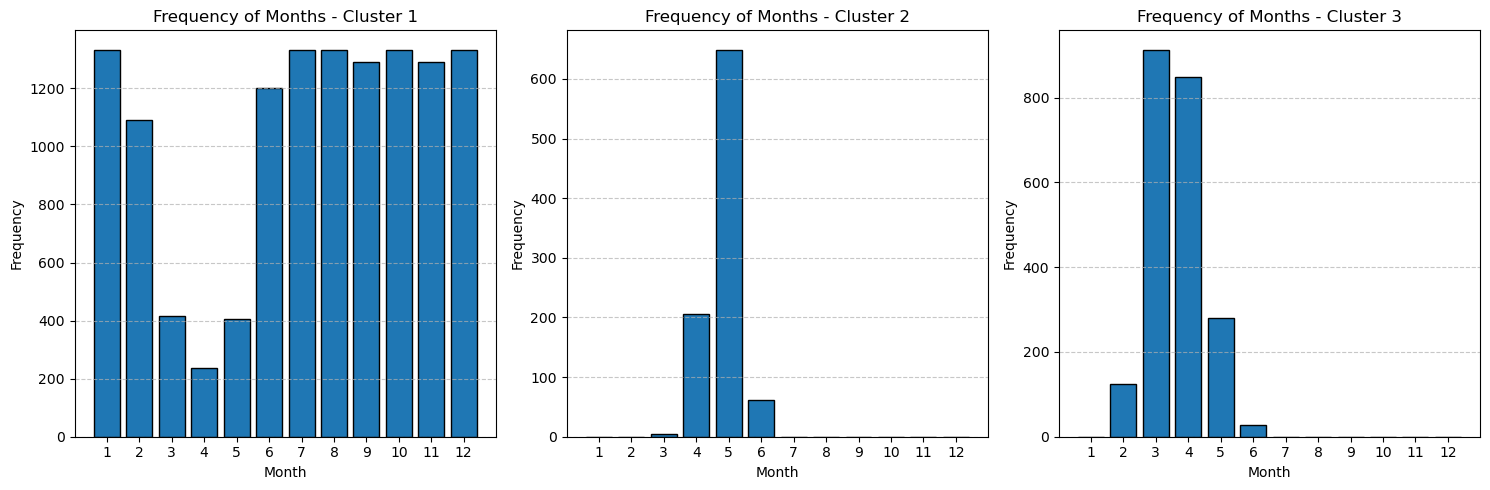

In [27]:
findseason(cluster_indices)

In [28]:
def cluster_and_average(cluster_indices, n_clusters, data):
    avg_clusters = []
    for i in range(n_clusters):
        cluster_data = data[cluster_indices[i]]
        avg_cluster = cluster_data.mean(axis=0)
        avg_clusters.append(avg_cluster)

    return avg_clusters



In [29]:
avg_clusters = cluster_and_average(cluster_indices, 3, temperature)

/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)
/home/ravi/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'clim'
  result = super().contourf(*args, **kwargs)


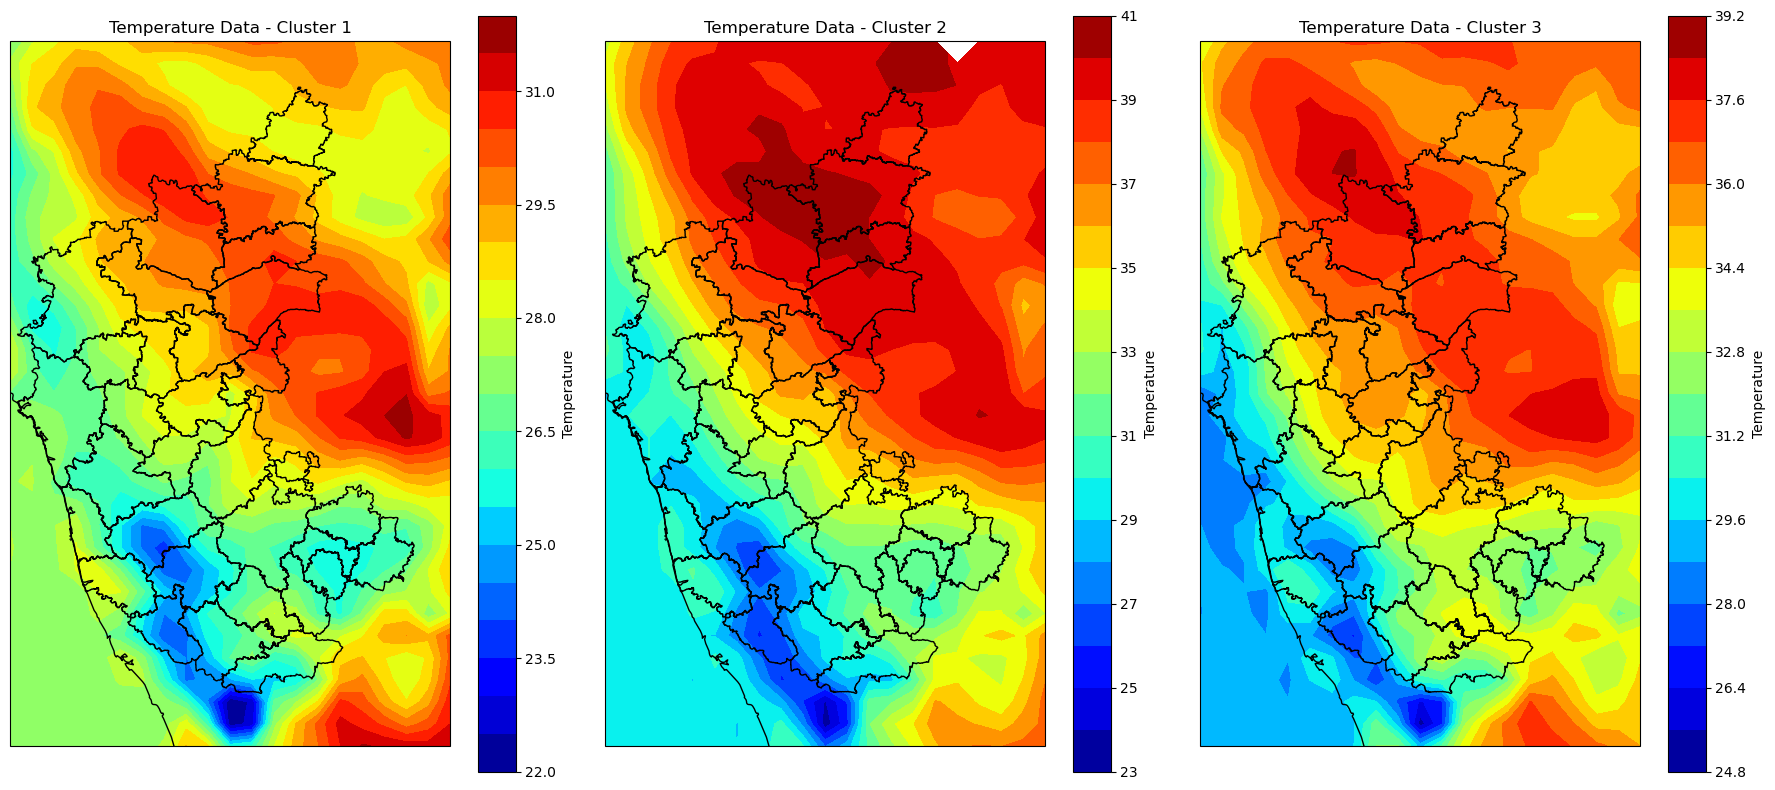

In [30]:
import geopandas as gpd
from cartopy import crs as ccrs

# Define the CRS for lon and lat data (e.g., Plate Carrée)
lon_lat_crs = ccrs.PlateCarree()

def plot_clusters(avg_clusters, district_shapefile_path):
    # Calculate the number of rows needed for 3 plots per row
    num_clusters = len(avg_clusters)
    num_rows = (num_clusters + 2) // 3  # Ceiling division to ensure at least 1 plot in the last row

    # Create a plot with three subplots per row
    fig, axs = plt.subplots(num_rows, 3, figsize=(18, 8 * num_rows), subplot_kw={'projection': lon_lat_crs})

    # Titles for each subplot
    titles = [f'Cluster {i+1}' for i in range(num_clusters)]

    # Load and reproject district boundaries
    districts = gpd.read_file(district_shapefile_path)  # Load district boundaries
    districts = districts.to_crs(lon_lat_crs.proj4_init)  # Reproject to lon/lat CRS

    # Loop through each subplot
    for i, ax in enumerate(axs.flat):
        if i < num_clusters:
            im = ax.contourf(lon, lat, avg_clusters[i], 20, transform=lon_lat_crs, cmap='jet', clim=(294,312))
            ax.coastlines()
            

            # Plot district boundaries
            districts.boundary.plot(ax=ax, color='black', linewidth=1)  # Adjust color and linewidth as needed

            ax.set_title(f'Temperature Data - {titles[i]}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, shrink=1)
            cbar.set_label('Temperature')
        else:
            # If there are empty subplots, remove them
            fig.delaxes(ax)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the path to your district shapefile
plot_clusters(avg_clusters, 'District.shp')


/tmp/ipykernel_33409/142326900.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet')


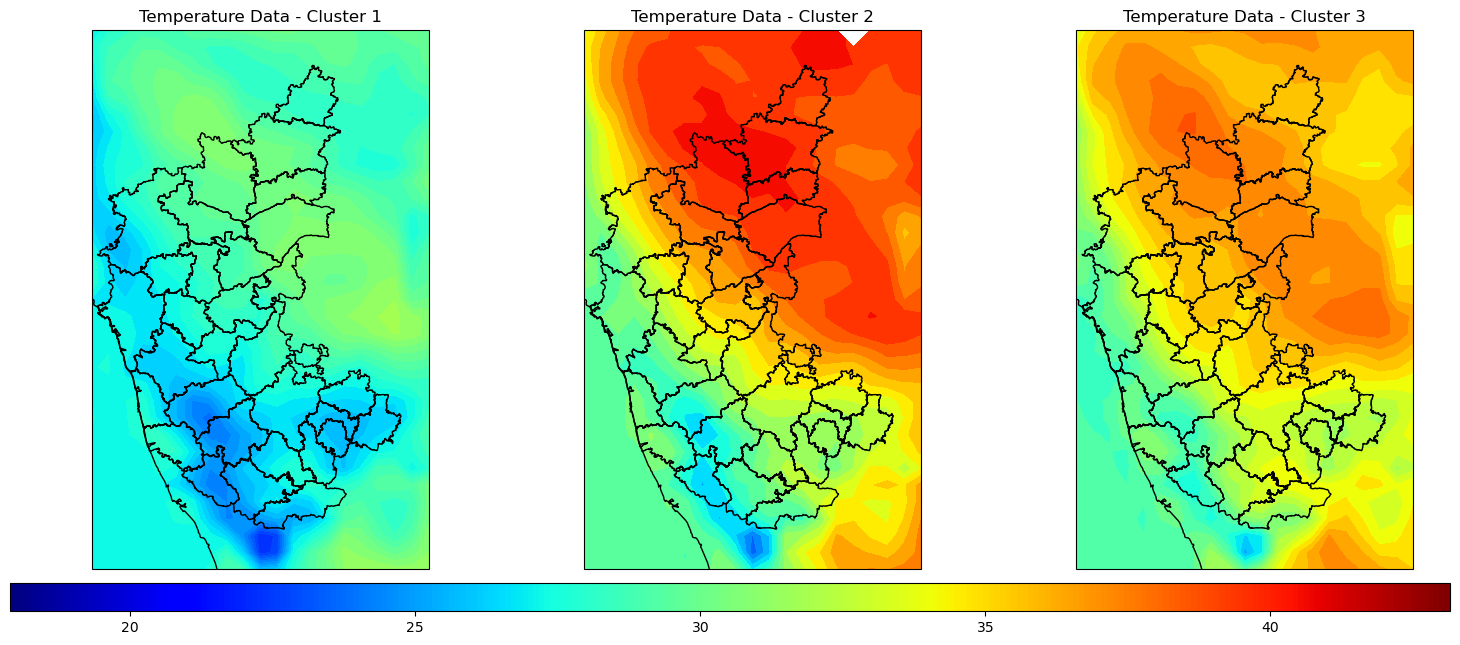

In [32]:
import geopandas as gpd
from cartopy import crs as ccrs
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Define the CRS for lon and lat data (e.g., Plate Carrée)
lon_lat_crs = ccrs.PlateCarree()
cmap=cm.get_cmap('jet')
normalizer=Normalize(21,41)
im0=cm.ScalarMappable(norm=normalizer,cmap=cmap)
def plot_same_clusters(avg_clusters, district_shapefile_path):
    # Calculate the number of rows needed for 3 plots per row
    num_clusters = len(avg_clusters)
    num_rows = (num_clusters + 2) // 3  # Ceiling division to ensure at least 1 plot in the last row
    vmin = min([temperature.min() for temperature in temperature])
    vmax = max([temperature.max() for temperature in temperature])
    #vmin=18;vmax=92.4
    # Create a plot with three subplots per row
    fig, axs = plt.subplots(num_rows, 3, figsize=(18, 7 * num_rows), subplot_kw={'projection': lon_lat_crs})

    # Titles for each subplot
    titles = [f'Cluster {i+1}' for i in range(num_clusters)]

    # Load and reproject district boundaries
    districts = gpd.read_file(district_shapefile_path)  # Load district boundaries
    districts = districts.to_crs(lon_lat_crs.proj4_init)  # Reproject to lon/lat CRS

    # Loop through each subplot
    for i, ax in enumerate(axs.flat):
        if i < num_clusters:
            im = ax.contourf(lon, lat, avg_clusters[i], 20, transform=lon_lat_crs, cmap='jet', norm=normalizer)#, vmin=vmin, vmax=vmax)
            ax.coastlines()
            im.set_clim(vmin, vmax)

            # Plot district boundaries
            districts.boundary.plot(ax=ax, color='black', linewidth=1)  # Adjust color and linewidth as needed

            ax.set_title(f'Temperature Data - {titles[i]}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            
        
        else:
            # If there are empty subplots, remove them
            fig.delaxes(ax)
            
    cbar = fig.add_axes([0.1, 0.05, 0.8, 0.04])
    fig.colorbar(im0, cax=cbar, shrink=0.9, orientation='horizontal')
    cbar.set_label('Temperature')

    # Adjust layout to prevent overlapping
    #plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the path to your district shapefile
plot_same_clusters(avg_clusters, 'District.shp')

